# <center>Post processing of ICA</center>

In this notebook we demonstrate how ICA can perform better than simple averaging over channels.

# Context

Let's build different type of situations where the sources that generate the data measured are known. We will first tackle situations with 2 sources and 2 sensors since the data is very easy to visualize in such situation. Samples of the 2 sources $S$ will be carried out for various type of distribution:
- sharply peaked sources
- unimodal and bimodal sources
- gaussian sources

The corresponding data measured $X$ stems from a linear mixture of sources $S$ perturbed by some noise $\epsilon$:

\begin{equation}
X=AS+\epsilon
\end{equation}

With $X$ and $S$ being arrays of shape:
- X: (d,n) where *d* is the dimension of the measures : we have **37 sensors**.
- S: (l,n) where *l* is the number of sources.
- *n* is the number of samples carried out in the measures.

# Generating data

In [1]:
# Before anything, import relevant modules
%load_ext autoreload
%autoreload 2

import autograd.numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from utils import plot_2D_distrib, mutual_information, analyze
from core import optim_ICA

rc('text', usetex=True)

SyntaxError: invalid syntax (<ipython-input-18-c75420725214>, line 1)

Let's generate some sources and measures. The matrix $A$ has a column almost constant. The number of sources used here is **totally arbitrary and unknown in real life**.

In [6]:
from benchmark import get_gaussian_noise, get_sharp
from utils import plot_A

n = 57
d = 37
l_virtual = 50
A_noise_ratio = 1/100

# IF YOU WANT TO SEE THE UTILITY OF ICA USE THIS LINE
A = A_noise_ratio*np.random.randn(d,l_virtual) + A_noise_ratio*(np.random.randn(d,l_virtual))**2

# IF YOU WANT TO SEE THE EQUIVALENCE BETWEEN ICA AND BLIND AVERAGING USE THIS LINE
A = A_noise_ratio*np.random.randn(d,l_virtual)

A[:,0] += np.ones(d)
#fig = plot_A(A)

In [8]:
import numpy.random as rr
import pandas as pd
from IPython.display import Markdown
import pygp as pygp
from utils import mean

def simul_planet_sources():
    # First step: read data from data subdirectory
    # keep only columns with time stamps and errors
    df = pd.read_csv('../data/HD189733_SOPHIE_listing.txt', sep='\s+', header=0, skiprows=[1,])

    # Select times in the big set
    t = df.bjd
    ind = (t > 54280) & (t < 54350)
    t = t[ind]
    print('There are {} points in the big set.'.format(sum(ind)))


    # Set seed for reproducible results
    rr.seed(20200429)

    # Fix amplitude to be 1.0 (arbitrary units?)
    a_planet = 1.0

    # Fix period by hand (maybe change in the future?)
    p_planet = 10 + rr.rand()

    # randomly draw phase (between 0 and 2pi)
    phi_planet = rr.rand() * 2*np.pi

    print('Planetary parameters')
    print('Amplitude', a_planet)
    print('Period', p_planet)
    print('Phase', phi_planet)

    # Build model 
    y = a_planet * np.sin(2*np.pi/p_planet * t + phi_planet)
    plt.figure()
    plt.scatter(t, y)
    plt.title('Planet rv signal')
    plt.show()
    
    # Fix seed again
    rr.seed(20200509)

    # Create parameters
    amp = 0.5
    per = rr.randn() * 2.0 + 24.0
    tau = 2 * per + rr.randn() * 0.1 * per 
    epsilon = rr.rand()

    # Create parameter list
    theta = [amp, tau, per, np.sqrt(epsilon)]
    labels = ['A', '$\\tau$', 'P', '$\\epsilon$']

    for par, l in zip(theta, labels):
        display(Markdown('Parameter {} = {}'.format(l, par)))
        
    # Create an instance of a quasi-periodic kernel.
    # Hyper parameters are: 1.0 for the amplitude and 0.1 for the length scale.
    qpk = pygpr.kernels.QuasiPeriodicKernel(theta)

    # Build a GP instance passing the Kernel instance and the input array 
    # (timestamps in the time series and oversampled times).
    mygp = pygpr.GaussianProcess(qpk, t)

    # Uncomment to give reproducible results
    rr.seed(20200209)

    # Produce a single sample from the "activity" model.
    yactivities = mygp.sample(size=l_virtual-1)
    
    # fusion of planet signal with activity
    sources = np.concatenate([[np.asarray(y)], yactivities])
    sources, _ = mean(sources)
    for source in sources:
        source /= (source.dot(source.T))**.5
    plt.figure()
    plt.plot(t, sources.T)
    plt.title('Planet signal diluted with activities, centered, normalized')
    plt.show()
    
    return t, sources

The corresponding data measured $X$ stems from a linear mixture of sources $S$ perturbed by some noise $\epsilon$:

\begin{equation}
X=AS+\epsilon
\end{equation}

In [9]:
noise_ratio = 10/100
noise = get_gaussian_noise(n=n, d=d, cov=noise_ratio*np.ones(d))
t, S = simul_planet_sources()

X = A.dot(S) + noise

There are 57 points in the big set.
Planetary parameters
Amplitude 1.0
Period 10.250449763542893
Phase 4.03617325307933


RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 432x288 with 1 Axes>

Parameter A = 0.5

Parameter $\tau$ = 52.596220620964274

Parameter P = 24.743841011564534

Parameter $\epsilon$ = 0.8582396349485545

NameError: name 'pygpr' is not defined

In [15]:
plt.figure()
plt.imshow(S.dot(S.T))
plt.title('Covariance estimation of used sources:')
plt.show()

NameError: name 'S' is not defined

<Figure size 432x288 with 0 Axes>

Importing personal methdods to custom ICA.

In [16]:
from heuristics import FOBI, V_manifold_optim, sk_FastICA, A_manifold_const, jadeR, PCA

In [17]:
def match_with_avg(sources, avg):
    l, n = sources.shape
    assert np.max(abs(np.sum(sources, axis=1)))<1e-10
    assert np.max(abs(sources.dot(sources.T)-np.eye(l)))<1e-8
    
    covs = sources.dot(avg.T)
    covs /= (avg.dot(avg.T))**.5
    return covs

def assess(covs):
    if len(covs)>1:
        probs = covs**2/np.sum(covs**2)
        probs_light = probs[probs.nonzero()]
        return np.sum(-probs_light*np.log(probs_light))
    else:
        return 1/abs(covs[0])

In [18]:
def gen_trust(res):
    return assess(res['covs'])

def post_process(results, results_meta, amplifier=lambda x:x, select_l=None):
    signals_list = []
    trustability = []
    for l, signals in results.items():
        if (select_l is None) or l==select_l:
            signals_list += signals
            trustability += list(map(gen_trust, results_meta[l]))

    return np.average(np.asarray(signals_list), weights=amplifier(np.asarray(trustability)), axis=0)

In [19]:
from matplotlib.colors import cnames
def instantaneous_epoch_plot(target_source_num, results, results_meta, step, S, avg):
    for l in target_source_num:
        try:
            guess[l] = post_process(results, results_meta, amplifier=lambda x:(x)**-10, select_l=l)
            print('Guess l='+str(l)+' epoch='+str(step)+' relative error: ', 100*np.average((guess[l]-S[0])**2)/np.average((S[0])**2), '%')
        except:
            pass
    guess['full'] = post_process(results, results_meta, amplifier=lambda x:(x)**-8)
    print('Guess full '+str(step)+' relative error: ', 100*np.average((guess['full']-S[0])**2)/np.average((S[0])**2), '%')
    print('AVG relative error: ', 100*np.average((avg-S[0])**2)/np.average((S[0])**2), '%')
    
    fig = plt.figure()
    #plt.scatter(t, S[0], label='Planet signal', marker='+')
    for l, signal in guess.items():
        try:
            plt.scatter(t, signal-S[0], label='Guessed '+str(l)+' signal', marker='x')
        except:
            pass
    plt.scatter(t, avg-S[0], label='Averaged signal', marker='x')
    #for l in [8,9,10]:
    #    for signal in results[l]:
    #        plt.scatter(t, signal, label=str(l), color=list(cnames.keys())[l])
    plt.grid(True)
    plt.legend()
    plt.title('Error to planet signal')
    return fig

In [20]:
order_threshold = 1.3

target_source_num = list(range(2,8))
results = {i: [] for i in range(38)}
results_meta = {i: [] for i in range(38)}
guess = {i: None for i in target_source_num}

In [21]:
steps = 100

In [22]:
for step in range(steps):
    #print(step)
    for l in target_source_num:
        #print('inspecting l=', l)

        res, params = optim_ICA(X, 
                                noise_fraction=200000/100,
                                verbose=False, 
                                constraints=['less-entropy'],
                                num_sources=l,
                                schedule=[sk_FastICA],)
        avg = params['X_chan_av']
        covs = match_with_avg(res[-1]['S'], avg)
        res[-1]['covs'] = covs
        
        if assess(covs)<order_threshold:
            #print('got with ', l, assess(covs))
            if False:
                plt.figure()
                plt.plot(covs**2/np.sum(covs**2))
                plt.title('s='+str(assess(covs)))
                plt.show()

            signal_ind = np.argmax(abs(covs))
            signal = res[-1]['S'][signal_ind]*np.sign(covs[signal_ind])

            results[l].append(signal)
            results_meta[l].append(res[-1])
            
    if step%10==1:
        instantaneous_epoch_plot(target_source_num, results, results_meta, step, S, avg)
        plt.show()

NameError: name 'X' is not defined

ICA guess relative error:  12.542221537984672 %
AVG relative error:  86.05152553090369 %


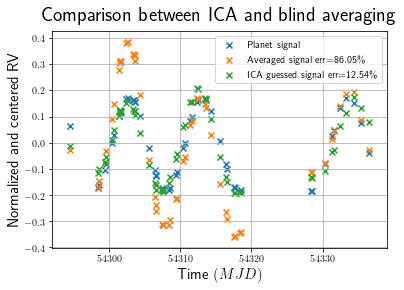

In [235]:
guess = post_process(results, results_meta, amplifier=lambda x:(x)**-8)
guess_err = 100*np.average((guess-S[0])**2)/np.average((S[0])**2)

avg_err = 100*np.average((avg-S[0])**2)/np.average((S[0])**2)

print('ICA guess relative error: ', guess_err, '%')
print('AVG relative error: ', avg_err, '%')


plt.scatter(t, S[0], label='Planet signal', marker='x')
plt.scatter(t, avg, label='Averaged signal err={:.2f}'.format(avg_err)+'\%', marker='x')
plt.scatter(t, guess, label='ICA guessed signal err={:.2f}'.format(guess_err)+'\%', marker='x')
plt.grid(True)
plt.legend()
plt.title('Comparison between ICA and blind averaging', fontsize=20, pad=10)
plt.xlabel(r'Time $(MJD)$', fontsize=15)
plt.ylabel(r'Normalized and centered RV', fontsize=15)
#plt.savefig('ICA_vs_avg_gain.png', dpi=200)
plt.show()

# References

[1] Jonathon Shlens, *A Tutorial on Independent Component Analysis*, arXiv:1404.2986v1, 2014  
[2] Cardoso, J., in *Acoustics, Speech, and Signal Processing, 1989. ICASSP-89., 1989 International Conference on* (IEEE), pp. 2109–2112, doi:10.1.1.8.5483, 1989  
[3] Jonathan  D.  Victor. Binless  strategies  for  estimation  of  information  from  neural  data. Physical  Review  E,  66(5):051903,  November  2002.   ISSN  1063-651X,  1095-3787.   doi:10.1103/PhysRevE.66.051903.